In [1]:
import argparse, time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
from dgl import graph_index
from dgl.graph_index import disjoint_partition
from dgl.data import citation_graph, CoraFull, RedditDataset
from dgl.data import AmazonCoBuy, Coauthor
from dgl.contrib.data import load_data
import math
from cacheout import Cache,LRUCache,MRUCache,LFUCache,FIFOCache,LIFOCache,RRCache

In [2]:
#Reddit = RedditDataset(self_loop=True)
#Enwiki = citation_graph.load_RMAT('enwiki',100,10)
Amazon = citation_graph.load_RMAT('amazon',1,10)
#_21M = citation_graph.load_RMAT('21',100,10)
#_22M = citation_graph.load_RMAT('22',50,10)
#_23M = citation_graph.load_RMAT('23',16,10)

load finish
Finished synthetic dataset generation.
  NumNodes: 8600000
  NumEdges: 231600000
  NumFeats: 1
  NumClasses: 10
  NumTrainingSamples: 5160000
  NumValidationSamples: 860000
  NumTestSamples: 2150000


In [3]:
DatasetList = [Amazon]

In [ ]:
-
        
    

In [17]:
data = load_data(args)
n_edges = data.graph.number_of_edges()
g = DGLGraph(data.graph)
degree = g.in_degrees()+g.out_degrees()
degree_sort = [i[0] for i in sorted(enumerate(degree), key=lambda x: x[1], reverse=True)]
degree_cache_value = [list() for _ in range(32)]
for val_ in degree_sort:
    degree_cache_value[val_%32].append(val_)

In [18]:
partition_size = 32
Node_index = []
Edge = []
Edge_number = []
partition_number = math.ceil(g.number_of_nodes() / partition_size)
print("the graph split to {:d} part". format(partition_number))
for node_id in range(partition_number):
    #print(node_id)
    if node_id == partition_number-1:
        index = list(range(partition_size*node_id,g.number_of_nodes()))
    else:
        index = list(range(partition_size*node_id,partition_size*(node_id+1)))
    Node_index.append(index)
    src, dst = g.out_edges(index)
    Edge.append(list(zip(src.tolist(),dst.tolist())))
    Edge_number.append(src.shape[0])

the graph split to 619 part


In [19]:
Total_size = [32,64,128,256,512,1024,2048,4096,8192,16384]
PrecentList = [1]
Hit = []
for pre in Total_size:
    Degree = Cache(pre)
    #CacheList = [LRU, MRU, LFU, FIFO, LIFO, RR]
    cache_hit = 0
    cache_miss = 0
    for id_ in degree_sort[0:pre-1]:
        Degree.set(id_, id_)
    for e in Edge:
        for val_ in e:
            src, dst = val_
            if Degree.has(dst):
                cache_hit = cache_hit + 1
            else:
                cache_miss = cache_miss + 1
    Hit.append(cache_hit)
    print('{}-hit={}, miss={}'.format(pre, cache_hit, cache_miss))

32-hit=3835, miss=123007
64-hit=6157, miss=120685
128-hit=9591, miss=117251
256-hit=14778, miss=112064
512-hit=22465, miss=104377
1024-hit=33653, miss=93189
2048-hit=49521, miss=77321
4096-hit=71364, miss=55478
8192-hit=98450, miss=28392
16384-hit=123432, miss=3410


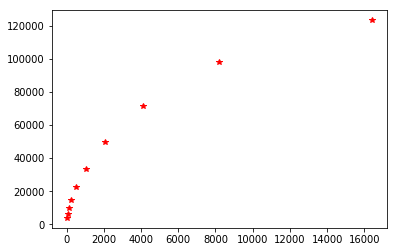

In [20]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(Total_size,Hit,'r*')

plt.show()